**Importing necessary libraries**

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno #visualizing and analyzing missing data patterns in datasets
from datetime import date
from sklearn.metrics import accuracy_score #calculates the accuracy score for a set of predicted labels against the true labels
from sklearn.model_selection import train_test_split #shuffles the dataset and then splits it
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
#Transform features by scaling each feature to a given range,

**Loading the datasets and printing their shape**

In [2]:
def big_dataset():
  data=pd.read_csv("./contents/application_train.csv")
  return data

def smaller_dataset():
  data=pd.read_csv("./contents/titanic.csv")
  return data

#see the shape of bigger _dataset
df=big_dataset()
print(df.shape)

#see the shape of smaller_dataset
dg=smaller_dataset()
print(dg.shape)

(307511, 122)
(891, 12)


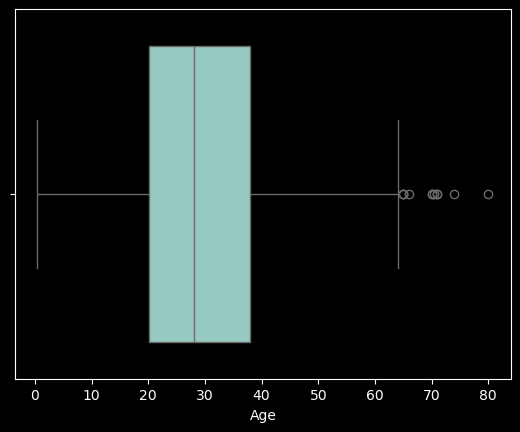

In [3]:
#using the titanic.csv
#we will detect the outliers in 'Age' column by using boxplot
sns.boxplot(x=dg['Age'])
plt.show()

In [4]:
q1=dg["Age"].quantile(0.25)
q3=dg["Age"].quantile(0.75)
iqr=q3-q1
up=q3+1.5*iqr
low=q1-1.5*iqr
print(up,low)

#see outliers
print(dg[(dg["Age"]<low) | (dg["Age"]>up)]) # less than low and more than up

64.8125 -6.6875
     PassengerId  Survived  Pclass                                  Name  \
33            34         0       2                 Wheadon, Mr. Edward H   
54            55         0       1        Ostby, Mr. Engelhart Cornelius   
96            97         0       1             Goldschmidt, Mr. George B   
116          117         0       3                  Connors, Mr. Patrick   
280          281         0       3                      Duane, Mr. Frank   
456          457         0       1             Millet, Mr. Francis Davis   
493          494         0       1               Artagaveytia, Mr. Ramon   
630          631         1       1  Barkworth, Mr. Algernon Henry Wilson   
672          673         0       2           Mitchell, Mr. Henry Michael   
745          746         0       1          Crosby, Capt. Edward Gifford   
851          852         0       3                   Svensson, Mr. Johan   

      Sex   Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33 

In [5]:
#index of outliers
print(dg[(dg["Age"]<low) | (dg["Age"]>up)].index)

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')


In [6]:
#any values below low
print(dg[(dg["Age"] < low)].any(axis=None))

False


In [7]:
#any values above up
print(dg[(dg["Age"] > up)].any(axis=None))

True


**A generalized function**


In [8]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

print(outlier_thresholds(dg, "Age"))

(-6.6875, 64.8125)


In [9]:
low, up = outlier_thresholds(dg, "Fare")
print(dg[(dg["Fare"] < low) | (dg["Fare"] > up)].head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
27           28         0       1   
31           32         1       1   
34           35         0       1   
52           53         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
27                     Fortune, Mr. Charles Alexander    male  19.0      3   
31     Spencer, Mrs. William Augustus (Marie Eugenie)  female   NaN      1   
34                            Meyer, Mr. Edgar Joseph    male  28.0      1   
52           Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0      1   

    Parch    Ticket      Fare        Cabin Embarked  
1       0  PC 17599   71.2833          C85        C  
27      2     19950  263.0000  C23 C25 C27        S  
31      0  PC 17569  146.5208          B78        C  
34      0  PC 17604   82.1708          NaN        C  
52      0  PC 17572   76.7292         

In [10]:
#Write a function that check if there is any outliers.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

print(check_outlier(dg, "Age"))
print(check_outlier(dg, "Fare"))


True
True


In [11]:
#We will try to grab categorical columns, categorical but cardinal columns and numerical columns
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f"cat_cols: {len(cat_cols)}")
  print(f"num_cols: {len(num_cols)}")
  print(f"cat_but_car: {len(cat_but_car)}")
  print(f"num_but_cat: {len(num_but_cat)}")

  return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(dg)
num_cols = [col for col in num_cols if col not in "PassengerId"]
print(num_cols)

#We will check outliers in numerical columns.
for col in num_cols:
    print(col, check_outlier(dg, col))



Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
['Age', 'Fare']
Age True
Fare True


application_train.csv

In [12]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols.remove('SK_ID_CURR')
print()
print()

#lets see which numerical columns have outliers
for col in num_cols:
  print(col,check_outlier(df,col))

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39


CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE True
FLOORSMIN_MODE True
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE Tru

In [13]:
#the function below will show us the outliers values for the associated column
#if there are outliers >10 , it will show first 5 if not then all
def grab_outliers(dataframe, col_name, outlier_index=False, f = 5):
    low, up = outlier_thresholds(dataframe, col_name) # Calculate low and up here

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head(f))
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if outlier_index:
        out_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return out_index

# Make sure 'df' is the correct DataFrame and has an 'Age' column
# If you are unsure, print df.columns to see the available columns
print(df.columns)

age_index=grab_outliers(df,"DAYS_BIRTH", True)
print(age_index)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)
Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION

In [14]:
#removing outliers from titanic.csv
low,up=outlier_thresholds(dg,"Fare")
#shape of the data with outliers
print(dg.shape)
#shape of the data without outliers
print(dg[~((dg["Fare"] < low) | (dg["Fare"] > up))].shape)

(891, 12)
(775, 12)


With function

In [15]:
def remove_outlier(dataframe, col_name):
  low,up=outlier_thresholds(dataframe,col_name)
  df_without_outliers=dataframe[~((dataframe[col_name]<low) | (dataframe[col_name]>up))]
  return df_without_outliers

cat_cols, num_cols, cat_but_car = grab_col_names(dg)
num_cols.remove('PassengerId')

for col in num_cols:
  dg=remove_outlier(dg,col)
print(dg.shape) #we removed 'Age' outliers and 'Fare' outliers

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
(765, 12)
